# Using Deep reinforcement learning to play Atari

![Q learning](fig/q-learning.png)

## Plan
* Random agent
* DQN agent
* Exploration / Experience replay 
* Double DQN
* Dueling DQN

Sharepoint link to [the slides](https://criteois-my.sharepoint.com/:p:/g/personal/j_mary_criteo_com/EYEBpa5o4IRBiwJ46Jqu8ykBtERXwaFoQAqtZHS4wyCNqg?e=pQsHaq) 

## Setup
### OpenAI Gym
OpenAI Gym is library that allows to train agents in a wide variety of environments with near-identical interface.
#### Installation
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```
### Keras
Keras is a high-level library on the top of deep learning backends (Tensorflow, Theano)
#### Installation
```
pip install keras
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

from utils import RLEnvironment, RLDebugger

import random

from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dense, Conv2D, Flatten, Input, Reshape, Lambda
from keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [3]:
env = RLEnvironment()
print(env.observation_space, env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Box(4,) Discrete(2)


In [4]:
env.run(RandomAgent(env.action_space))

NameError: name 'RandomAgent' is not defined

## Gym API key elements
* env = gym.make(environment_name) <- sets up the environment
* env.reset() <- resets the environment to starting point
* env.step(action) <- takes action and goes to state $S_{t+1}$, returns $r_t$, $S_{t+1}$ and if game terminated.
* env.render() <- render the output

## Tensorboard logging
*Optional* - If your backend is Tensorflow you can observe some parameters during the training using the board
```
tensorboard --logdir=/tmp/logs --port=8000
```
but you need to set callbacks in the code 
```
tensorboard_cback = keras.callbacks.TensorBoard(log_dir='/tmp/logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
model.fit(...inputs and parameters..., callbacks=[tensorboard_cback])
```
more details in the documentation https://keras.io/callbacks/#tensorboard and on [Stackoverflow](https://stackoverflow.com/questions/42112260/how-do-i-use-the-tensorboard-callback-of-keras) 


## Random agent
Walkthrough. Make sure to ask if the code needs clarification.

In [5]:
class RandomAgent:
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def get_action(self, state):
        return self.action_space.sample()

## Play loop
Walkthrough. 
Note that this Gym environment is considered as solved as soon as you find a policy which scores 200 on average.

In [ ]:
env.run(RandomAgent(env.action_space), episodes=20, display_policy=True)


## DQN Agent - Online
Here it is a keras code for training a DQN without exploration. 

It is presented first for the sake of clarity. Nevertheless, the trained network is immediatly used to collect the new training data, unless you are *very* lucky you won't be able to find a way to solve the task. 

Just replace the `???` by some parameters which seems reasonnable to you ($\gamma>1$ is not reasonnable and big steps are prone to numerical instability) and watch the failure of the policy training. 

In [17]:
class DQNAgent(RLDebugger):
    def __init__(self, observation_space, action_space):
        RLDebugger.__init__(self)
        # get size of state and action
        self.state_size = observation_space.shape[0]
        self.action_size = action_space.n
        # hyper parameters 
        self.gamma = .995
        self.learning_rate = .001
        self.model = self.build_model()  
        self.target_model = self.model
        
    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        #This is a simple one hidden layer model, thought it should be enough here,
        #it is much easier to train with different achitectures (stack layers, change activation)
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        # 1/ You can try different losses. As an logcosh loss is a twice differenciable approximation of Huber loss
        # 2/ From a theoretical perspective Learning rate should decay with time to guarantee convergence 
        return model

    # get action from model using greedy policy. 
    def get_action(self, state):
        q_value = self.model.predict(state)
        best_action = np.argmax(q_value[0]) #The [0] is because keras outputs a set of predictions of size 1
        return best_action

    # train the target network on the selected action and transition
    def train_model(self, action, state, next_state, reward, done):
        target = self.model.predict(state)
        # We use our internal model in order to estimate the V value of the next state 
        target_val = self.target_model.predict(next_state)
        # Q Learning: target values should respect the Bellman's optimality principle
        if done: #We are on a terminal state
            target[0][action] = reward
        else:
            target[0][action] = reward + self.gamma * (np.amax(target_val))

        # and do the model fit!
        loss = self.model.fit(state, target, verbose=0).history['loss'][0]
        self.record(action, state, target, target_val, loss)        

In [18]:
agent = DQNAgent(env.observation_space, env.action_space)
env.run(agent)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_17 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode 10, Total reward 10.0
Episode 20, Total reward 9.0
Episode 30, Total reward 8.0
Episode 40, Total reward 11.0
Episode 50, Total reward 10.0
Episode 60, Total reward 10.0
Episode 70, Total reward 9.0
Episode 80, Total reward 10.0
Episode 90, Total reward 8.0
Episode 100, Total reward 10.0
Average Total Reward of last 100 episodes: 9.29


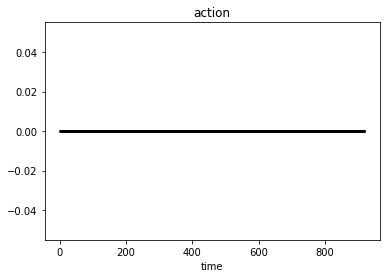

In [19]:
agent.plot_actions()

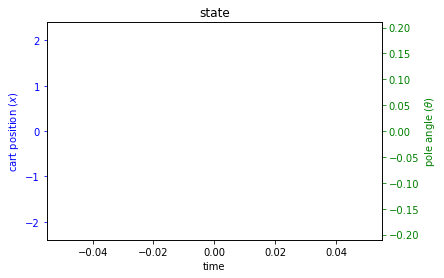

In [27]:
agent.plot_state()

## DQN Agent with Exploration
This is our first agent which is going to solve the task. It will typically require to run a few hundred of episodes to collect the data. 

The difference with the previous agent is that you are going to add an exploration mechanism in order to take care of the data collection for the training. We advise to use an $\varepsilon_n$-greedy, meaning that the value of $\varepsilon$ is going to decay over time. Several kind of decays can be found in the litterature, a simple one is to use a mutiplicative update of $\varepsilon$ by a constant smaller than 1 as long as $\varepsilon$ is smaller than a small minimal rate (typically in the range 1%-5%).

You need to:
* Code your exploration (area are tagged in the code by some TODOs).
* Tune the hyperparameters (including the ones from the previous section) in order to solve the task. This may be not so easy and will likely require more than 500 episodes and a final small value of epsilon. Next sessions will be about techniques to increase sample efficiency (i.e require less episodes).

**Trouble shooting:** *some working parameters and network architecture are provided at the bottom of this page in case you have trouble finding a working situation.*

In [21]:
class DQNAgentWithExploration(DQNAgent):
    def __init__(self, observation_space, action_space):
        super(DQNAgentWithExploration, self).__init__(observation_space, action_space)
        # exploration schedule parameters 
        self.epsilon_base = .99
        self.t = 0
        self.epsilon = 1
        self.n_first_exploration_steps = 30
        # TODO store your additional parameters here 

    # decay epsilon
    def update_epsilon(self):
        # TODO write the code for your decay  
        self.t += 1
        self.epsilon = self.epsilon_base ** np.sqrt(self.t-self.n_first_exploration_steps) if self.t > self.n_first_exploration_steps else 1
        self.learning_rate = self.learning_rate ** np.sqrt(self.t-self.n_first_exploration_steps) if self.t > self.n_first_exploration_steps else self.learning_rate

    # get action from model using greedy policy
    def get_action(self, state):
        #TODO add the exploration 
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        q_value = self.model.predict(state)
        return np.argmax(q_value[0])

In [22]:
agent = DQNAgentWithExploration(env.observation_space, env.action_space)
env.run(agent, episodes=500, print_delay=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_20 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode 50, Total reward 15.0
Episode 100, Total reward 19.0
Episode 150, Total reward 14.0
Episode 200, Total reward 45.0
Episode 250, Total reward 11.0
Episode 300, Total reward 11.0
Episode 350, Total reward 18.0
Episode 400, Total reward 11.0
Episode 450, Total reward 11.0
Episode 500, Total reward 16.0
Average Total Reward of last 100 episodes: 29.68


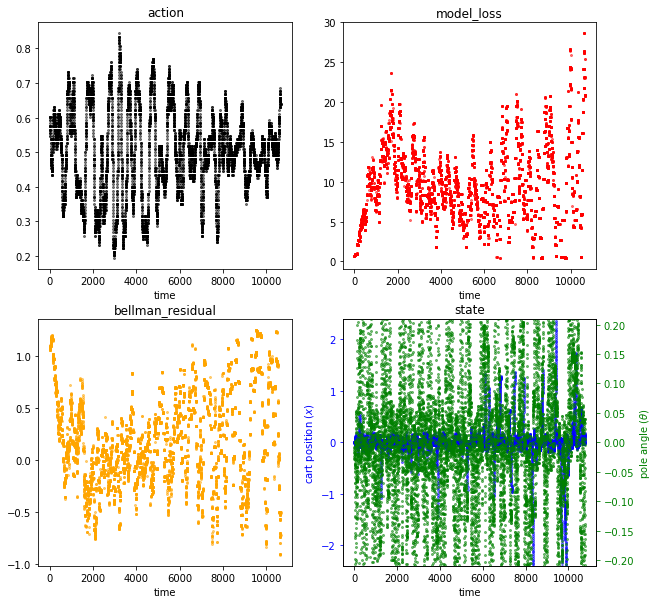

In [23]:
agent.plot_diagnostics()

## DQN Agent with Exploration and Experience Replay

We are now going to save some samples in a limited memory in order to build minibatches during the training. The exploration policy remains the same than in the previous section.  Storage is already coded you just need to modify the tagged section which is about building the mini-batch sent to the optimizer.

In [35]:
from collections import deque

class DQNAgentWithExplorationAndReplay(DQNAgentWithExploration):
    def __init__(self, observation_space, action_space):
        super(DQNAgentWithExplorationAndReplay, self).__init__(observation_space, action_space)
        self.batch_size = 32
        self.train_start = 64
        # create replay memory using deque
        self.memory = deque(maxlen=5000)
        self.loss = 0

    def create_minibatch(self):
        # pick samples randomly from replay memory (using batch_size)
        
        batch_size = min(self.batch_size, len(self.memory))
        samples = random.sample(self.memory, batch_size)
        
        states = np.array([_[0][0] for _ in samples])
        actions = np.array([_[1] for _ in samples])
        rewards = np.array([_[2] for _ in samples])
        next_states = np.array([_[3][0] for _ in samples])
        dones = np.array([_[4] for _ in samples])
        
        return (states, actions, rewards, next_states, dones)
        
    def train_model(self, action, state, next_state, reward, done):
        
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
        
        if len(self.memory) >= self.train_start:
            states, actions, rewards, next_states, dones = self.create_minibatch()
            
            targets = self.model.predict(states)
            target_values = self.target_model.predict(next_states)

            for i in range(self.batch_size):
                # Approx Q Learning
                if dones[i]:
                    targets[i][actions[i]] = rewards[i]
                else:
                    targets[i][actions[i]] = rewards[i] + self.gamma * (np.amax(target_values[i]))
           
            # and do the model fit!
            loss = self.model.fit(states, targets, verbose=0).history['loss'][0]
            
            for i in range(self.batch_size):
                self.record(actions[i], states[i], targets[i], target_values[i], loss)

In [ ]:
agent = DQNAgentWithExplorationAndReplay(env.observation_space, env.action_space)
env.run(agent, episodes=1000, print_delay=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_35 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode 50, Total reward 47.0
Episode 100, Total reward 14.0
Episode 150, Total reward 138.0
Episode 200, Total reward 200.0
Episode 250, Total reward 46.0
Episode 300, Total reward 200.0
Episode 350, Total reward 10.0
Episode 400, Total reward 10.0
Episode 450, Total reward 200.0
Episode 500, Total reward 178.0
Episode 550, Total reward 99.0
Episode 600, Total reward 200.0
Episode 650, Total reward 200.0

In [ ]:
agent.plot_diagnostics()

## Double DQN Agent with Exploration and Experience Replay

Now we want to have two identical networks and keep frozen for some timesteps the one which is in charge of the evaluation (*i.e* which is used to compute the targets).
Note that you can find some variants where the target network is updated at each timestep but with a small fraction of the difference with the policy network.

In [ ]:
class DoubleDQNAgentWithExplorationAndReplay(DQNAgentWithExplorationAndReplay):
    def __init__(self, observation_space, action_space):
        super(DoubleDQNAgentWithExplorationAndReplay, self).__init__(observation_space, action_space)
        # TODO: initialize a second model
        self.target_model = self.build_model()

    def update_target_model(self):
        # TODO copy weights from the model used for action selection to the model used for computing targets
        self.target_model.set_weights(self.model.get_weights())

In [ ]:
agent = DoubleDQNAgentWithExplorationAndReplay(env.observation_space, env.action_space)
env.run(agent, episodes=100, print_delay=10)

In [ ]:
agent.plot_diagnostics()

To observe actual performance of the policy we should set $\varepsilon=0$

In [ ]:
agent.epsilon = 0
env.run(agent, episodes=100, print_delay=10)

In [ ]:
agent.plot_diagnostics()

## Duelling DQN 

If time allows, adapt the description from http://torch.ch/blog/2016/04/30/dueling_dqn.html to our setting

# More ideas
* Compute averaged curves over several initialisations for each algorithm,
* Shape the reward in order to keep the cart close to it's initial position, 
* Do not sample uniformly in the memory for the batches, use https://arxiv.org/pdf/1511.05952.pdf
* (Painfull) Learn a policy with a bar starting from the bottom position,
* Use an other environment providing pictures, replace the network by a pre-trained ResNet-50 and learn a policy to play your favorite Atari game (can easily take days of computation if not done asynchroneously on several V100 as described by https://github.com/dgriff777/rl_a3c_pytorch),
* Visualize important areas of the pictures for taking the decision using saliency maps computed by guided backpropagation as shown by http://arxiv.org/abs/1412.6806.
* Go to policy gradient methods 

# Spoiler
Some working parameters for the network: 
* gamma = 0.995
* learning_rate = 0.001
* Exploration by $\varepsilon$-greddy with multiplicative decay and minimal value 
  ```
  self.epsilon = 1.0
  self.epsilon_decay = 0.995
  self.epsilon_min = 0.01
  ```
* Structure of the network: 2 couches de 24 neurones complètement connectées avec activation relu, Cost MSE et optimisé par descente de gradient Adam:
  ```
  model.add(Dense(24, input_dim=self.state_size, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(self.action_size, activation='linear'))
  model.summary()
  model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
  ```
        